In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import statsmodels.api as sm
import scipy.stats as stats
import warnings

from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")

In [141]:
from collections import defaultdict
from typing import Dict, Any, Optional
import re
import matplotlib.pyplot as plt
import seaborn as sns

def parse_multiplos_mapeamentos(linhas: list[str]) -> Dict[str, str]:
    """
    Extrai múltiplos pares 'codigo = descricao' de uma mesma linha.
    """
    resultado: Dict[str, str] = {}

    padrao = re.compile(r'(\w+)\s*=\s*([A-Za-zÀ-ÿ().\s]+)')

    for linha in linhas:
        for codigo, descricao in padrao.findall(linha):
            resultado[codigo.strip()] = descricao.strip()

    return resultado


def mapear_variaveis_categoricas(
    dicionario_json: Dict[str, Dict[str, Any]],
) -> Dict[str, Dict[str, str]]:
    """
    Mapeia automaticamente variáveis categóricas do ENADE
    a partir de texto bruto no formato 'CHAVE = VALOR'.
    """
    categorias = defaultdict(dict)

    for col, meta in dicionario_json.items():
        valores = meta.get("Categoria")

        # só processa se for texto
        if not isinstance(valores, str):
            continue

        linhas = [l.strip() for l in valores.split("\n") if l.strip()]

        # 🔥 Caso especial: UF / campos com dois pares por linha
        if col == "CO_UF_CURSO":
            categorias[col] = parse_multiplos_mapeamentos(linhas)
            continue

        for linha in linhas:
            if "=" not in linha:
                continue

            if linha.lower().startswith(("min", "max")):
                continue

            if linha.startswith(("*", ".", "(")):
                continue

            chave, valor = linha.split(" = ", 1)
            categorias[col][chave.strip()] = valor.strip()

    return dict(categorias)

def plot_boxplot_by_group(
    data,
    group_col: str,
    value_col: str = "NT_GER",
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: str = "Nota Geral (NT_GER)",
    rotate_xticks: bool = True,
    label_maps: Optional[Dict[str, Dict[Any, str]]] = None,
):
    """
    Plota boxplot agrupado e, se disponível, substitui os rótulos do eixo X
    usando mapeamento categórico (ex: ENADE).
    """
    plt.figure(figsize=(18, 9))

    ax = sns.boxplot(
        x=group_col,
        y=value_col,
        data=data
    )

    plt.title(title if title else f"{value_col} por {group_col}")
    plt.xlabel(xlabel if xlabel else group_col)
    plt.ylabel(ylabel)

    # 🔥 Aqui acontece a mágica
    if label_maps and group_col in label_maps:
        mapping = label_maps[group_col]

        labels = []
        for tick in ax.get_xticklabels():
            raw = tick.get_text()
            labels.append(mapping.get(raw, mapping.get(int(raw), raw)))

        ax.set_xticklabels(labels)

    if rotate_xticks:
        plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()



##### Carregando base do ENADE 2017

In [163]:
def convert_num(x):
    try:
        return float(x.replace(',', '.').strip())
    except:
        return pd.NA

df_base = pd.read_csv(
        'MICRODADOS_ENADE_2017.txt', 
        sep=';', 
        encoding='latin1',
        converters={
            'NT_OBJ_CE': convert_num,
            'NT_GER': convert_num
        }
    )

df_dicionario = pd.read_excel('Dicionário de variáveis dos Microdados do Enade_Edição 2017.xlsx', sheet_name='DICIONÁRIO', header=1)
df_base.shape

df_base["NT_GER"] = pd.to_numeric(df_base["NT_GER"], errors="coerce")

In [31]:
df_base.head()

,NU_ANO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I72,QE_I73,QE_I74,QE_I75,QE_I76,QE_I77,QE_I78,QE_I79,QE_I80,QE_I81
0,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
df_dicionario = pd.read_excel(
    "Dicionário de variáveis dos Microdados do Enade_Edição 2017.xlsx",
    sheet_name="DICIONÁRIO",
    header=1
)

colunas = [
    "CO_CATEGAD", "CO_ORGACAD", "CO_GRUPO", "CO_MODALIDADE", "CO_UF_CURSO",
    "CO_REGIAO_CURSO", "NU_IDADE", "TP_SEXO", "ANO_FIM_EM", "ANO_IN_GRAD",
    "CO_TURNO_GRADUACAO", "TP_INSCRICAO_ADM", "TP_PR_GER", "NT_GER",
    "CO_RS_I1", "CO_RS_I3", "CO_RS_I4", "CO_RS_I5", "CO_RS_I6", "CO_RS_I7",
    "CO_RS_I8", "CO_RS_I9", "QE_I01", "QE_I02", "QE_I03", "QE_I04", "QE_I05",
    "QE_I06", "QE_I07", "QE_I08", "QE_I09", "QE_I10", "QE_I11", "QE_I12",
    "QE_I13", "QE_I14", "QE_I15", "QE_I16", "QE_I17", "QE_I18", "QE_I19",
    "QE_I20", "QE_I21", "QE_I22", "QE_I23", "QE_I24", "QE_I25", "QE_I26"
]

df_variaveis = df_dicionario[df_dicionario["Nome"].isin(colunas)]

# Gera dicionário chave → descrição
dicionario_json = (
    df_variaveis.drop(columns=["Nº"])
                .set_index("Nome")
                .to_dict(orient="index")
)

In [167]:
dicionario_json['CO_GRUPO']['Categoria'].strip().split('\n')

['21 = Arquitetura e Urbanismo',
 '72 = Tecnologia em Análise e Desenvolvimento de Sistemas',
 '76 = Tecnologia em Gestão da Produção Industrial',
 '79 = Tecnologia em Redes de Computadores',
 '701 = Matemática (Bacharelado)',
 '702 = Matemática (Licenciatura)',
 '903 = Letras-Português (Bacharelado)',
 '904 = Letras-Português (Licenciatura)',
 '905 = Letras-Português e Inglês (Licenciatura)',
 '906 = Letras-Português e Espanhol (Licenciatura)',
 '1401 = Física (Bacharelado)',
 '1402 = Física (Licenciatura)',
 '1501 = Química (Bacharelado)',
 '1502 = Química (Licenciatura)',
 '1601 = Ciências Biológicas (Bacharelado)',
 '1602 = Ciências Biológicas (Licenciatura)',
 '2001 = Pedagogia (Licenciatura)',
 '2401 = História (Bacharelado)',
 '2402 = História (Licenciatura)',
 '2501 = Artes Visuais (Licenciatura)',
 '3001 = Geografia (Bacharelado)',
 '3002 = Geografia (Licenciatura)',
 '3201 = Filosofia (Bacharelado)',
 '3202 = Filosofia (Licenciatura)',
 '3502 = Educação Física (Licenciatura)'

In [169]:
mapas = mapear_variaveis_categoricas(dicionario_json)

#### Bloco teórico

##### Instituição

In [32]:
colunas_institucionais = [
    "CO_CATEGAD", "CO_ORGACAD", "CO_MODALIDADE", "CO_REGIAO_CURSO",
    "CO_UF_CURSO", "CO_GRUPO", "NT_GER"
]

df_institucional = df_base[colunas_institucionais]
df_institucional.head()

,CO_CATEGAD,CO_ORGACAD,CO_MODALIDADE,CO_REGIAO_CURSO,CO_UF_CURSO,CO_GRUPO,NT_GER
0,1,10028,1,5,51,5710,52.6
1,1,10028,1,5,51,5710,63.1
2,1,10028,1,5,51,5710,33.7
3,1,10028,1,5,51,5710,58.1
4,1,10028,1,5,51,5710,46.3


In [ ]:
for col in dicionario_json.keys():
    if col in df_institucional.columns:
        # df_institucional[col].attrs['description'] = dicionario_json[col]['Descrição']
        print(f"Coluna: {col}\nDescrição: {dicionario_json[col]['Descrição']}\nCategorias:\n{dicionario_json[col]['Categoria']}")
        print("-----" * 10)

In [39]:
df_institucional = df_institucional.dropna(subset=["NT_GER"])
df_institucional.shape

(449932, 7)

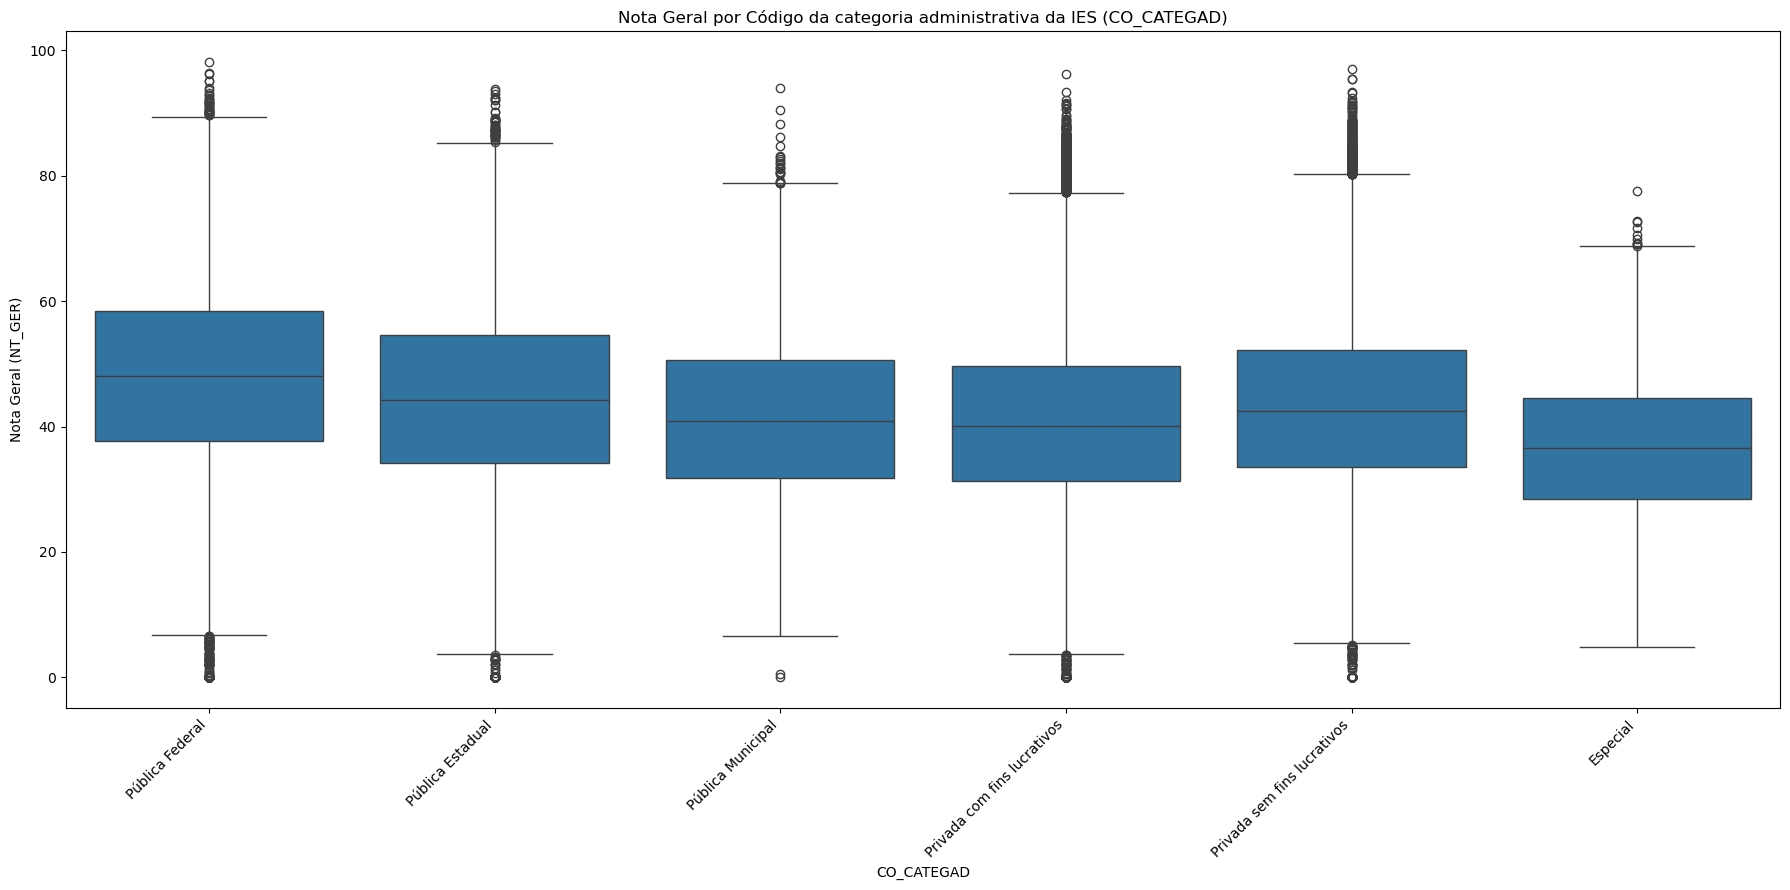

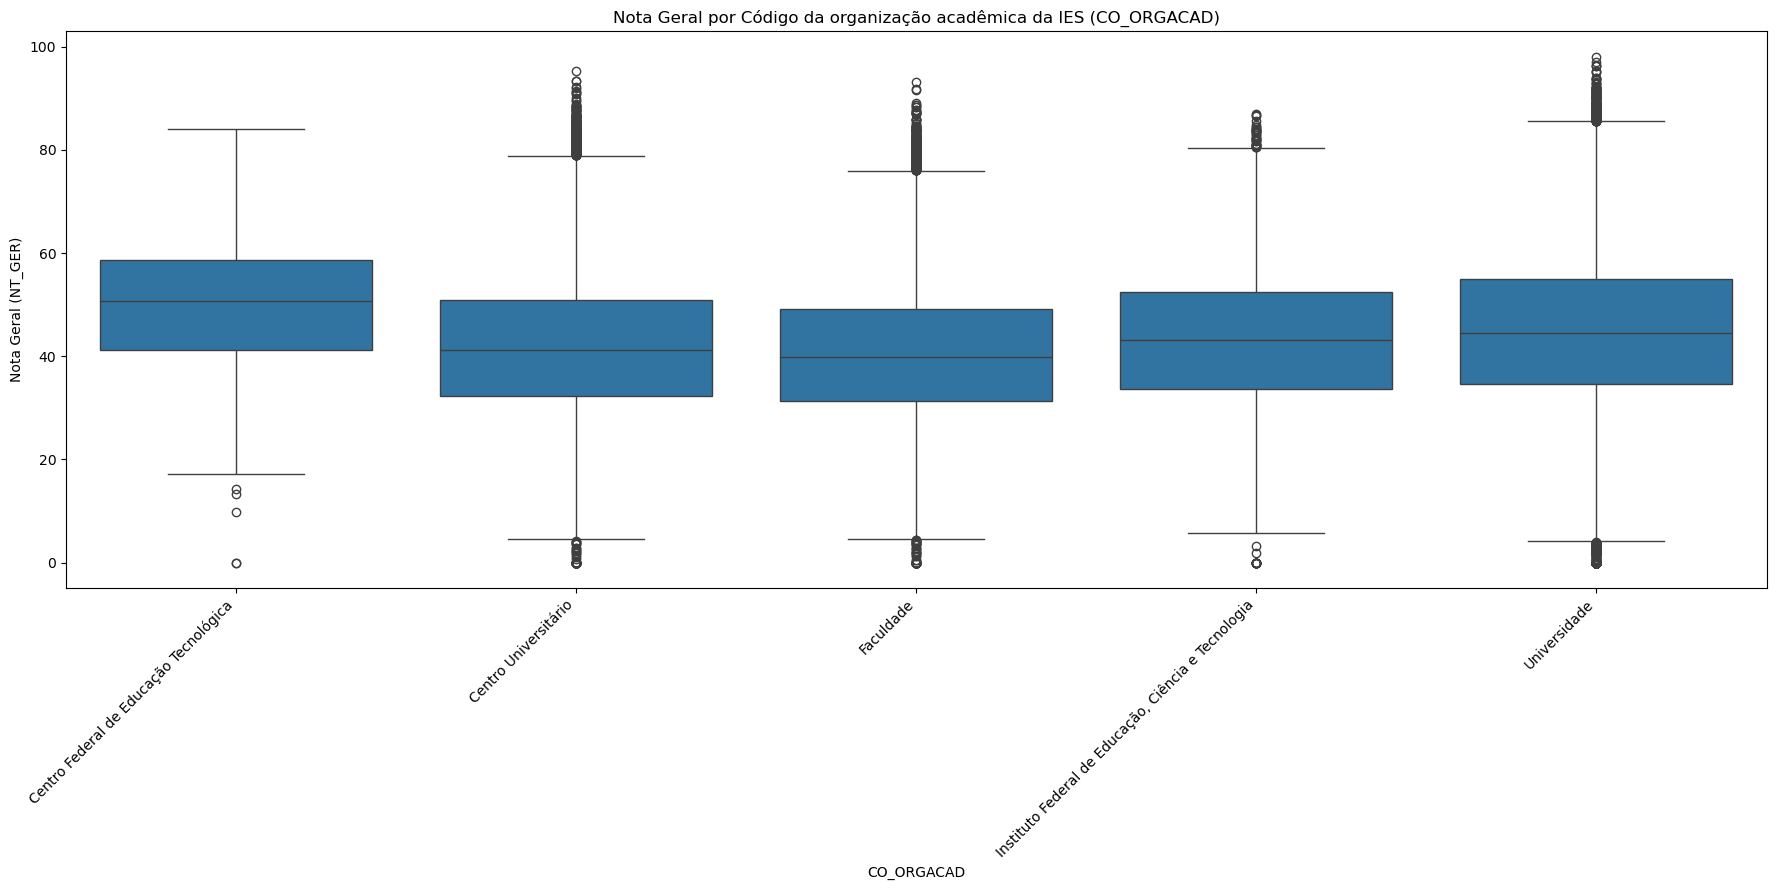

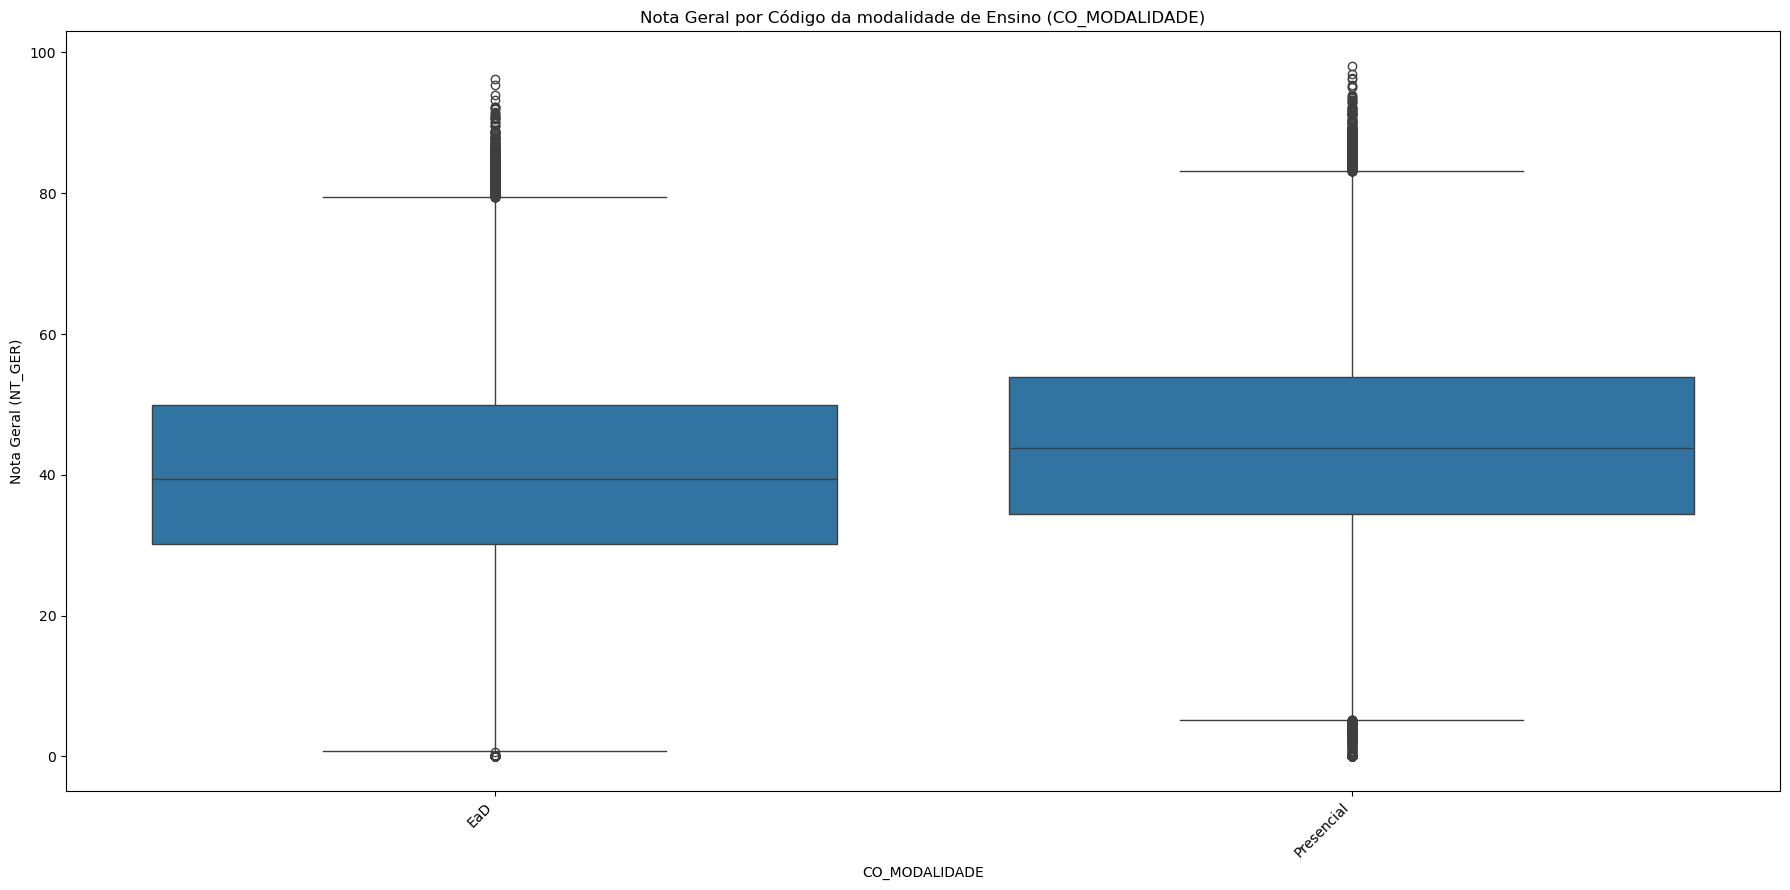

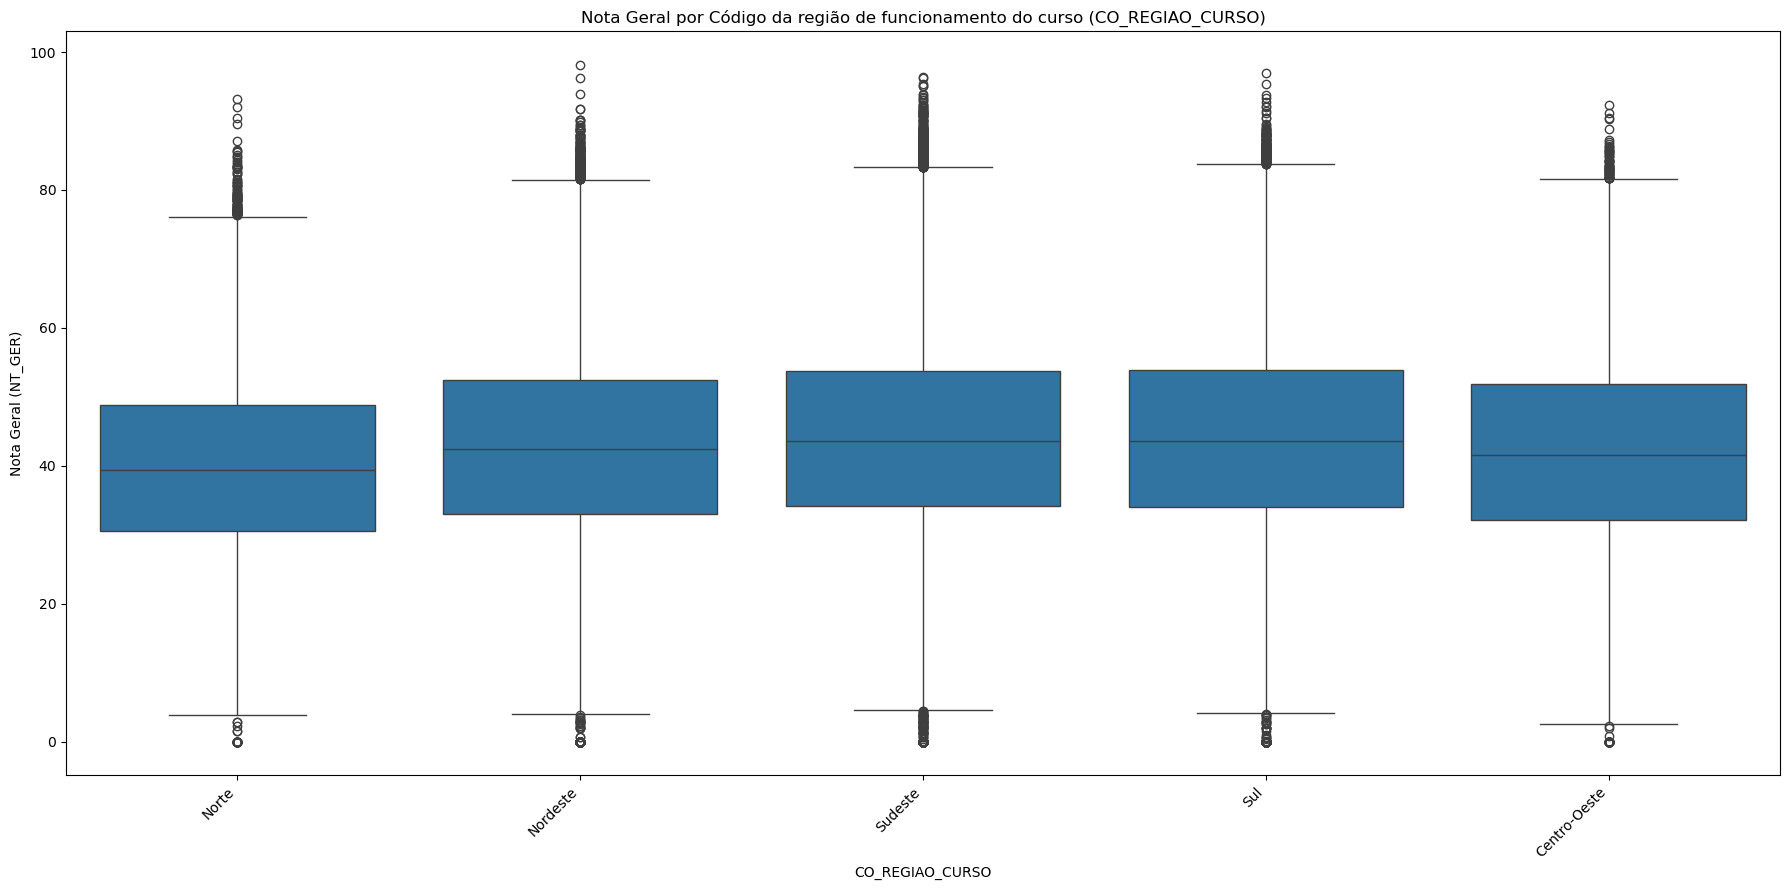

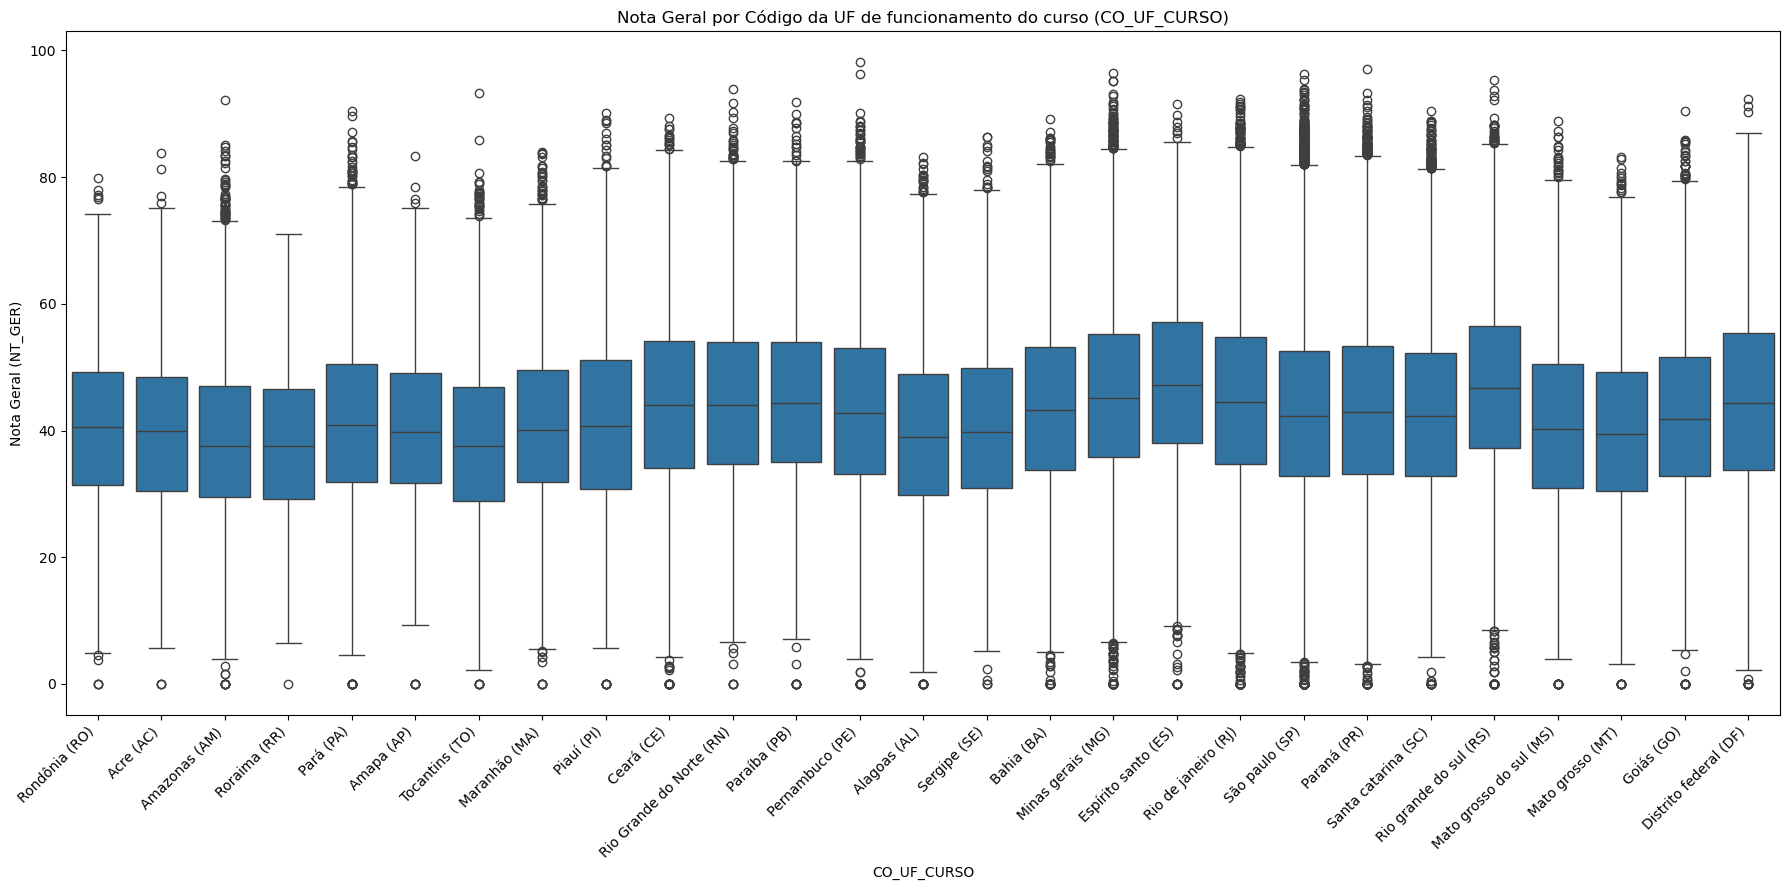

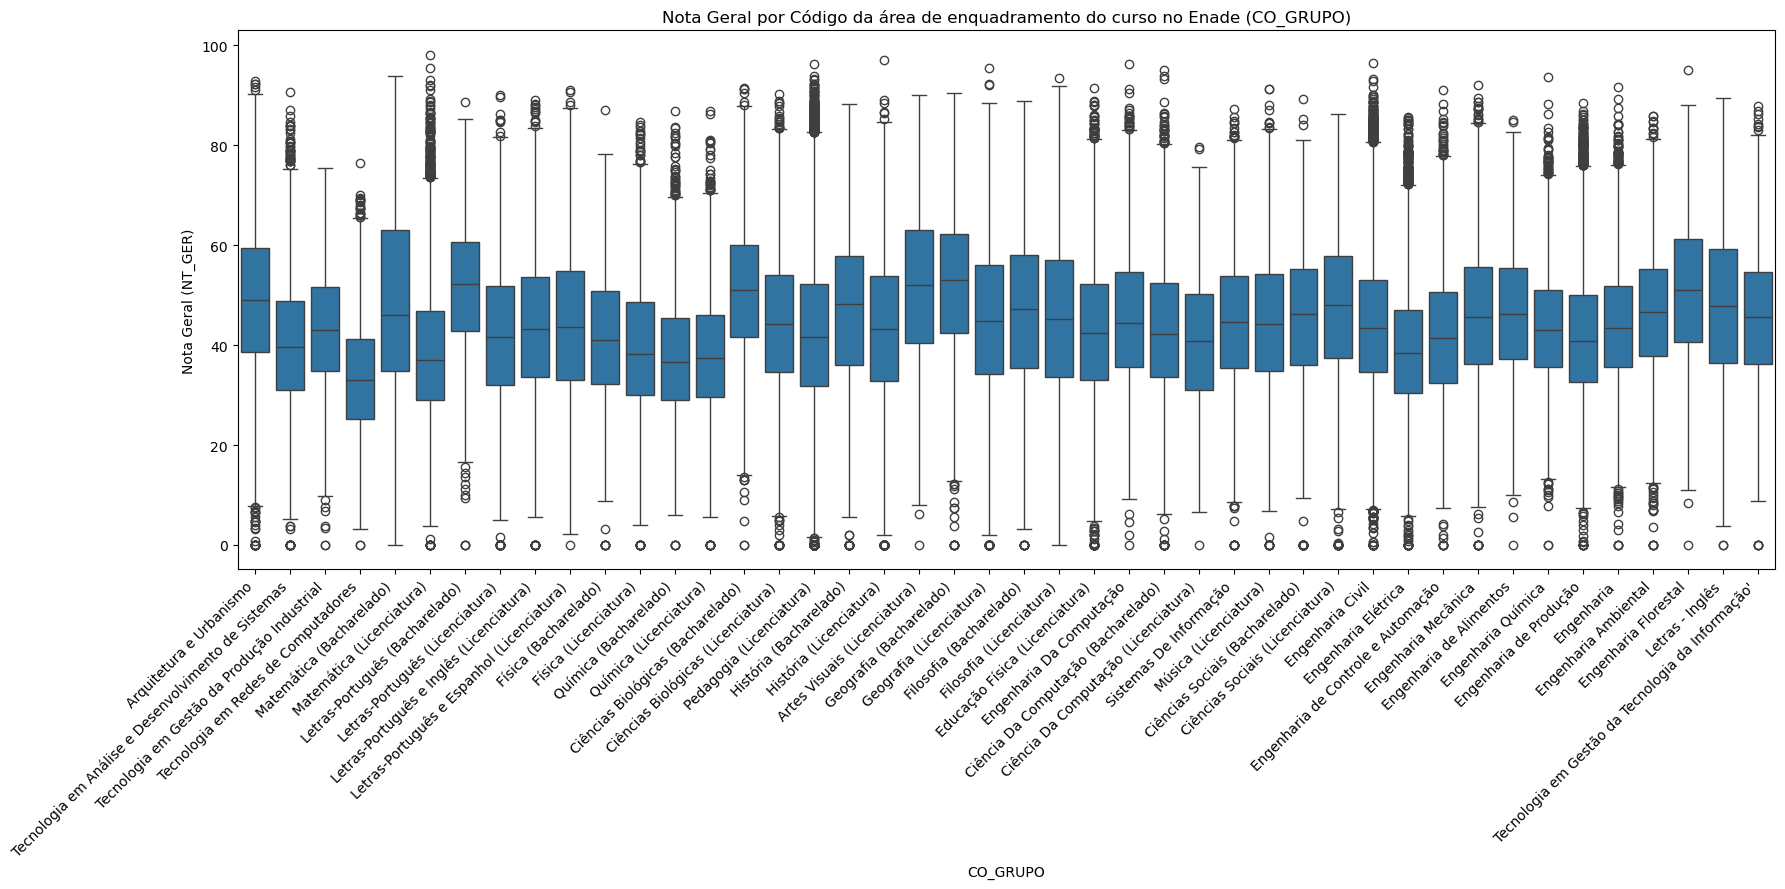

In [170]:
cols = df_institucional.columns.to_list()
cols.remove('NT_GER')

for col in cols:
    title = dicionario_json[col]['Descrição']
    plot_boxplot_by_group(
        data=df_institucional,
        group_col=col,
        value_col='NT_GER',
        title=f'Nota Geral por {title} ({col})',
        label_maps=mapas
    )

In [ ]:
def normalizar_codigo(valor):
    if isinstance(valor, float) and valor.is_integer():
        return str(int(valor))
    return str(valor)


def imprimir_linha_traduzida(linha, mapas):
    for col, valor in linha.items():
        codigo = normalizar_codigo(valor)
        valor_legivel = mapas.get(col, {}).get(codigo, valor)
        print(f"{col}: {valor_legivel}")

linha_max = df_institucional.loc[df_institucional['NT_GER'].idxmax()]

imprimir_linha_traduzida(linha_max, mapas)

print("\n" + "-----" * 10)

linhas_min = df_institucional[df_institucional['NT_GER'] == 0]

for idx, linha in linhas_min.iterrows():
    print(f"\nLinha índice {idx}")
    imprimir_linha_traduzida(linha, mapas)


In [193]:
df_zero = df_institucional[df_institucional["NT_GER"] == 0].copy()
print(f"Total de observações com NT_GER = 0: {len(df_zero)}")

df_90 = df_institucional[df_institucional["NT_GER"] >= 90].copy()
print(f"Total de observações com NT_GER >= 90: {len(df_90)}")

Total de observações com NT_GER = 0: 690
Total de observações com NT_GER >= 90: 71


In [191]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_count_categorico(
    data,
    col,
    mapas,
    top_n=None,
    title=None,
    horizontal=False,
    ascending=True
):
    # Normaliza série
    serie = data[col].astype(str)

    # Contagem ordenada
    contagem = serie.value_counts(ascending=ascending)

    if top_n:
        contagem = contagem.head(top_n)

    categorias_ordenadas = contagem.index.tolist()

    data_plot = data[data[col].astype(str).isin(categorias_ordenadas)]

    plt.figure(figsize=(12, 9))

    if horizontal:
        ax = sns.countplot(
            y=data_plot[col].astype(str),
            order=categorias_ordenadas
        )
    else:
        ax = sns.countplot(
            x=data_plot[col].astype(str),
            order=categorias_ordenadas
        )

    # Tradução dos rótulos
    if col in mapas:
        labels = []
        ticks = ax.get_yticklabels() if horizontal else ax.get_xticklabels()

        for tick in ticks:
            raw = tick.get_text()
            labels.append(mapas[col].get(raw, raw))

        if horizontal:
            ax.set_yticklabels(labels)
        else:
            ax.set_xticklabels(labels)

    plt.title(title if title else f"Distribuição de NT_GER = 0 por {col}")
    plt.tight_layout()
    plt.show()


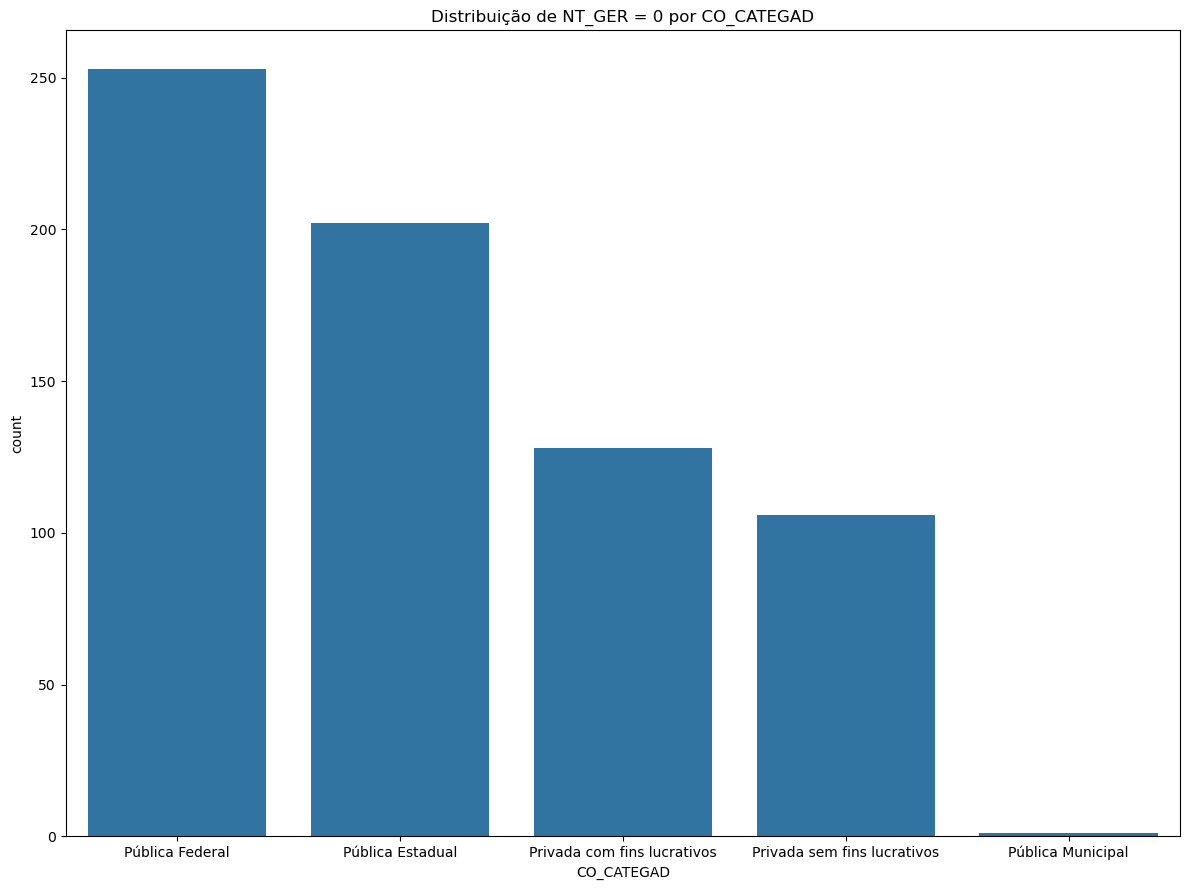

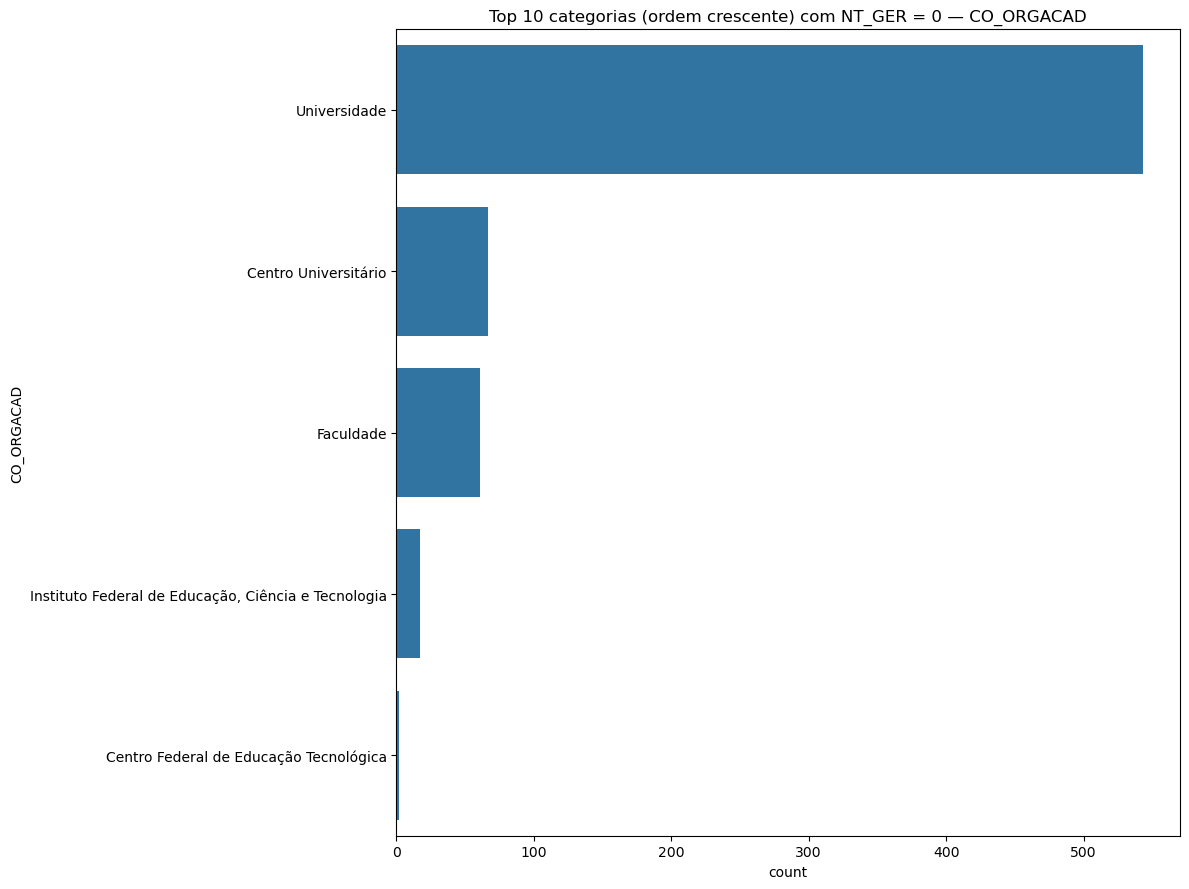

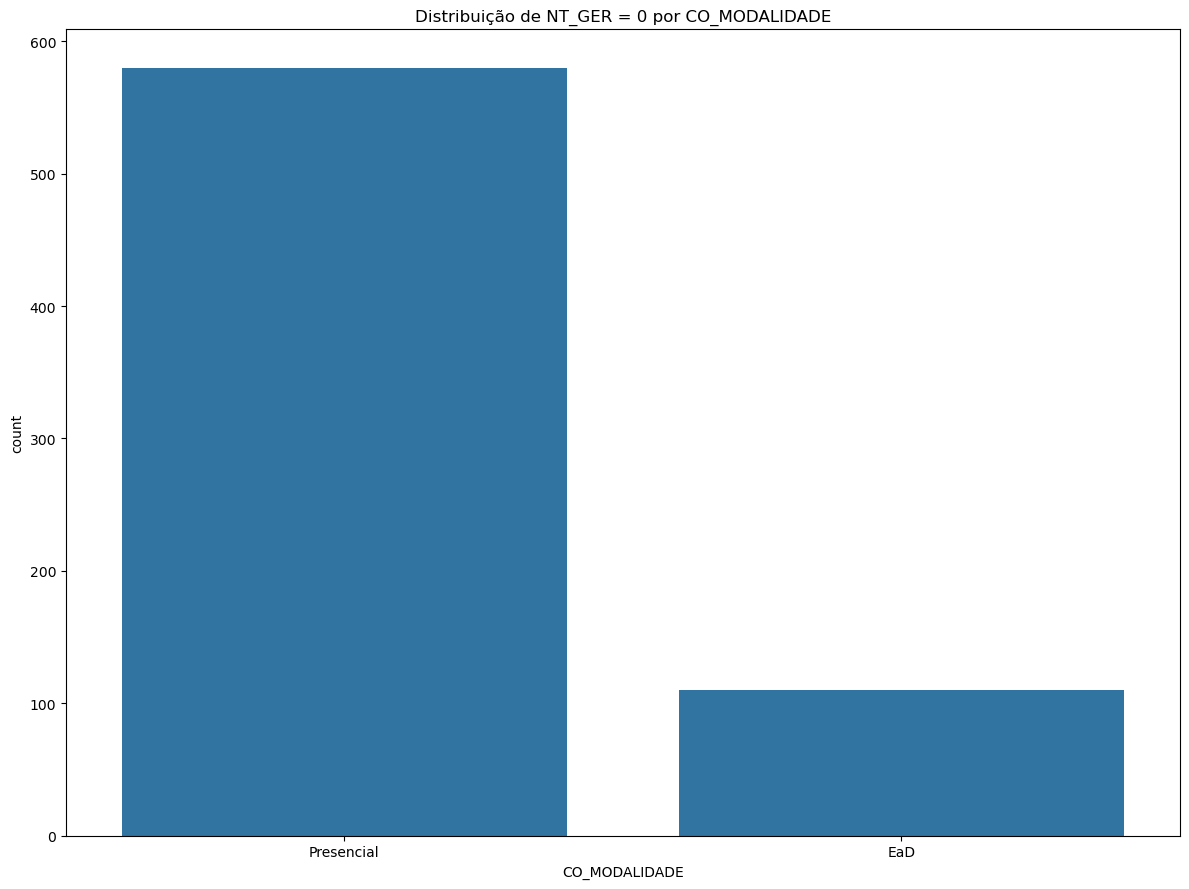

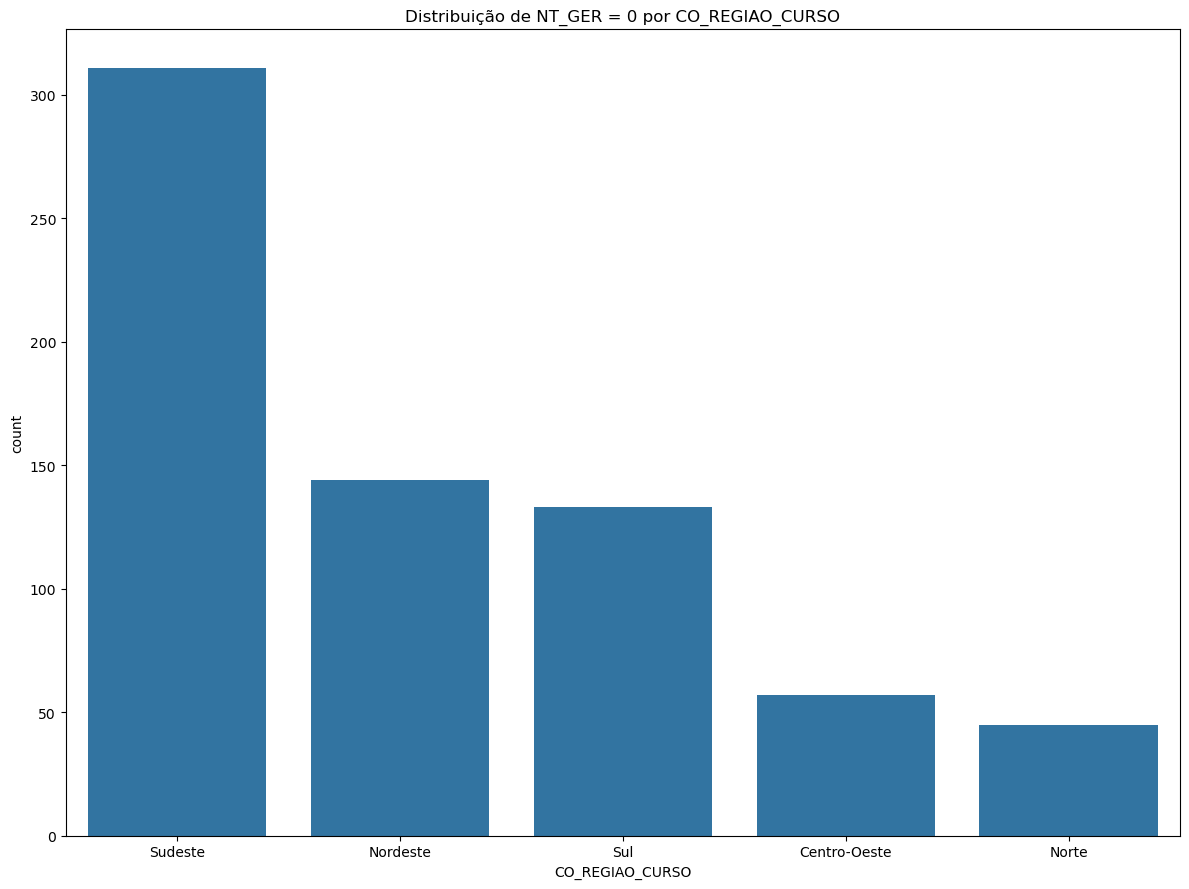

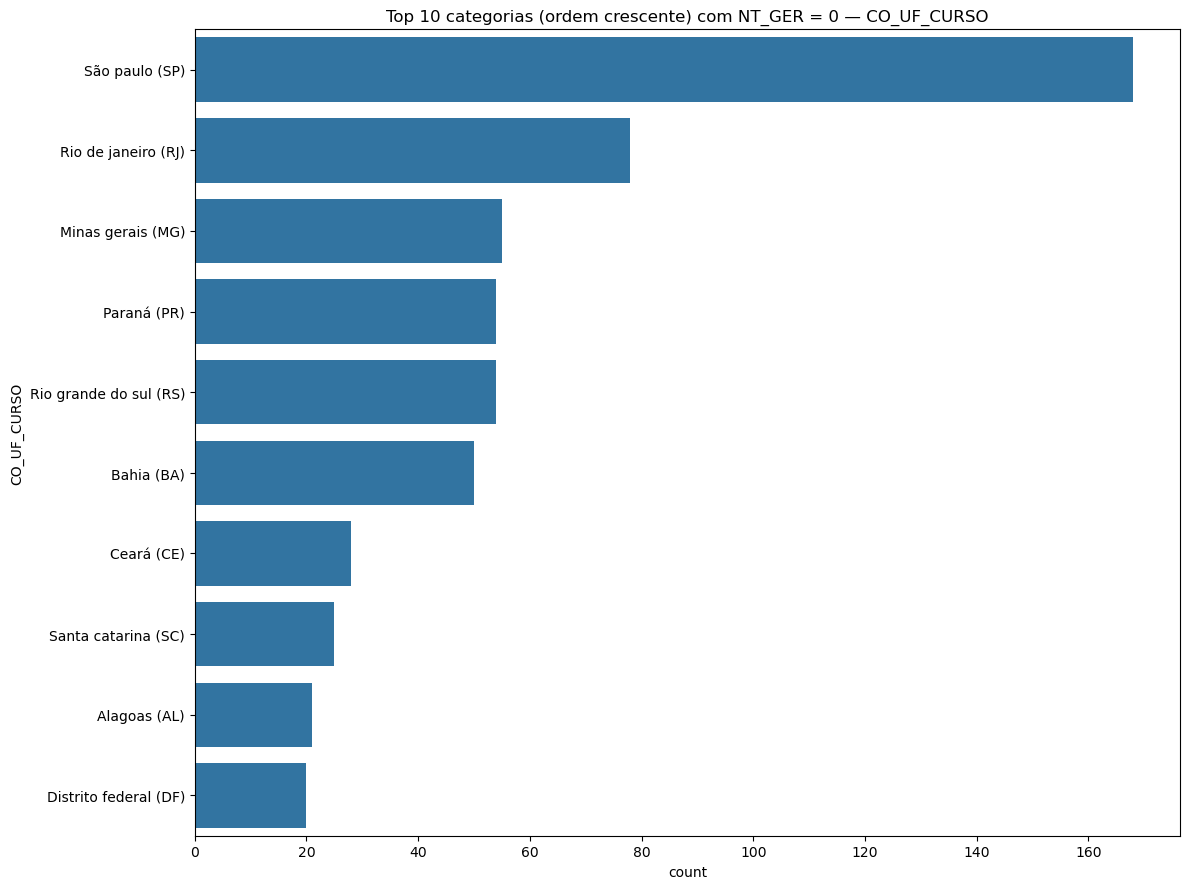

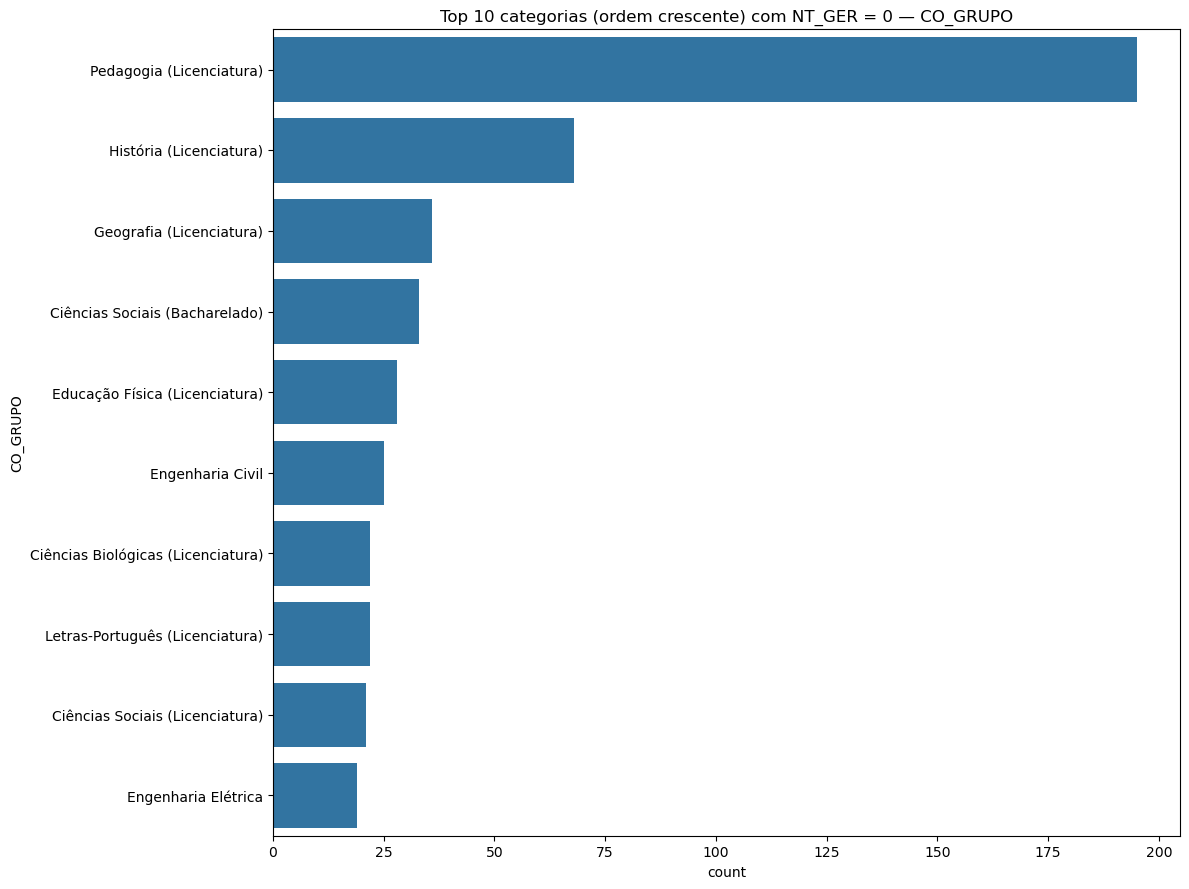

In [192]:
cols_analise = [
    "CO_CATEGAD",
    "CO_ORGACAD",
    "CO_MODALIDADE",
    "CO_REGIAO_CURSO",
    "CO_UF_CURSO",
    "CO_GRUPO",
]

high_cardinality = {"CO_UF_CURSO", "CO_GRUPO", "CO_ORGACAD"}

for col in cols_analise:
    is_high = col in high_cardinality

    plot_count_categorico(
        data=df_zero,
        col=col,
        mapas=mapas,
        top_n=10 if is_high else None,
        horizontal=is_high,
        ascending=False,
        title=(
            f"Top 10 categorias (ordem crescente) com NT_GER = 0 — {col}"
            if is_high
            else f"Distribuição de NT_GER = 0 por {col}"
        )
    )


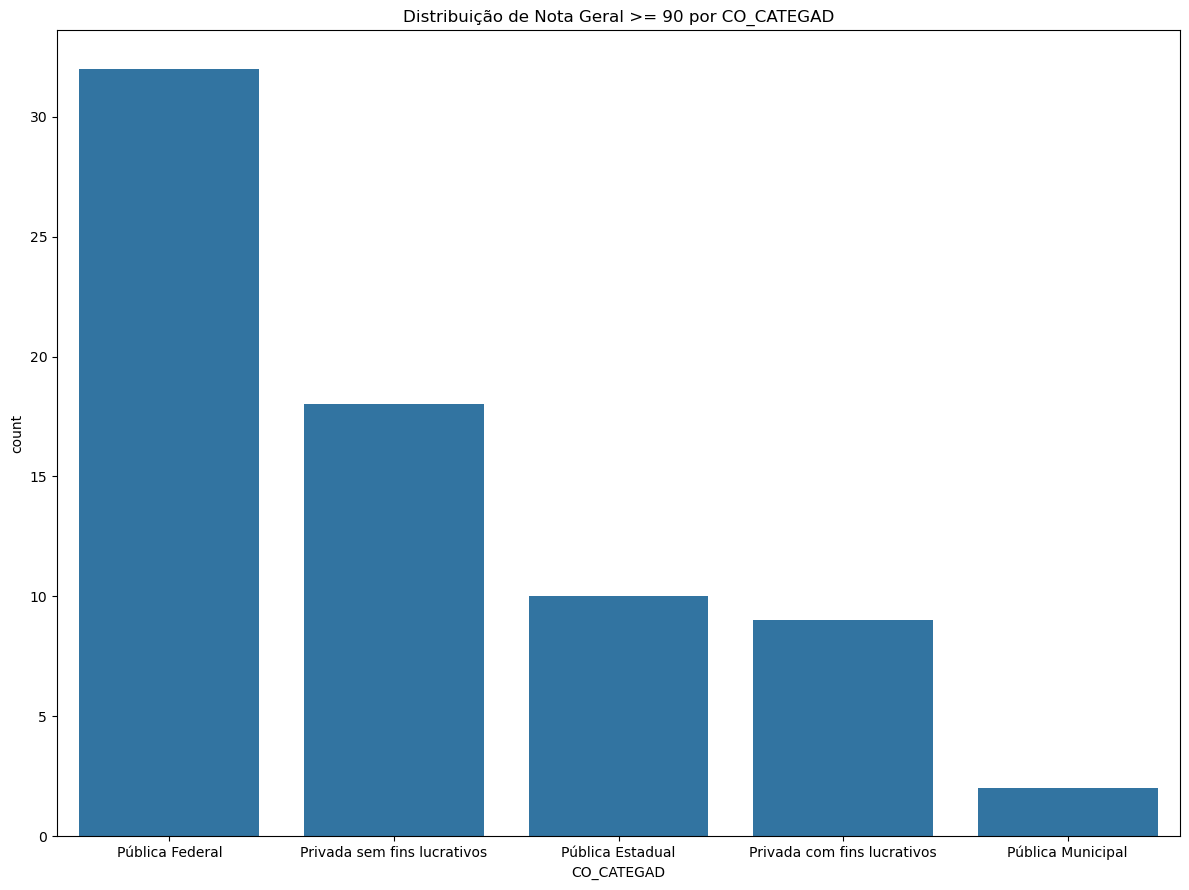

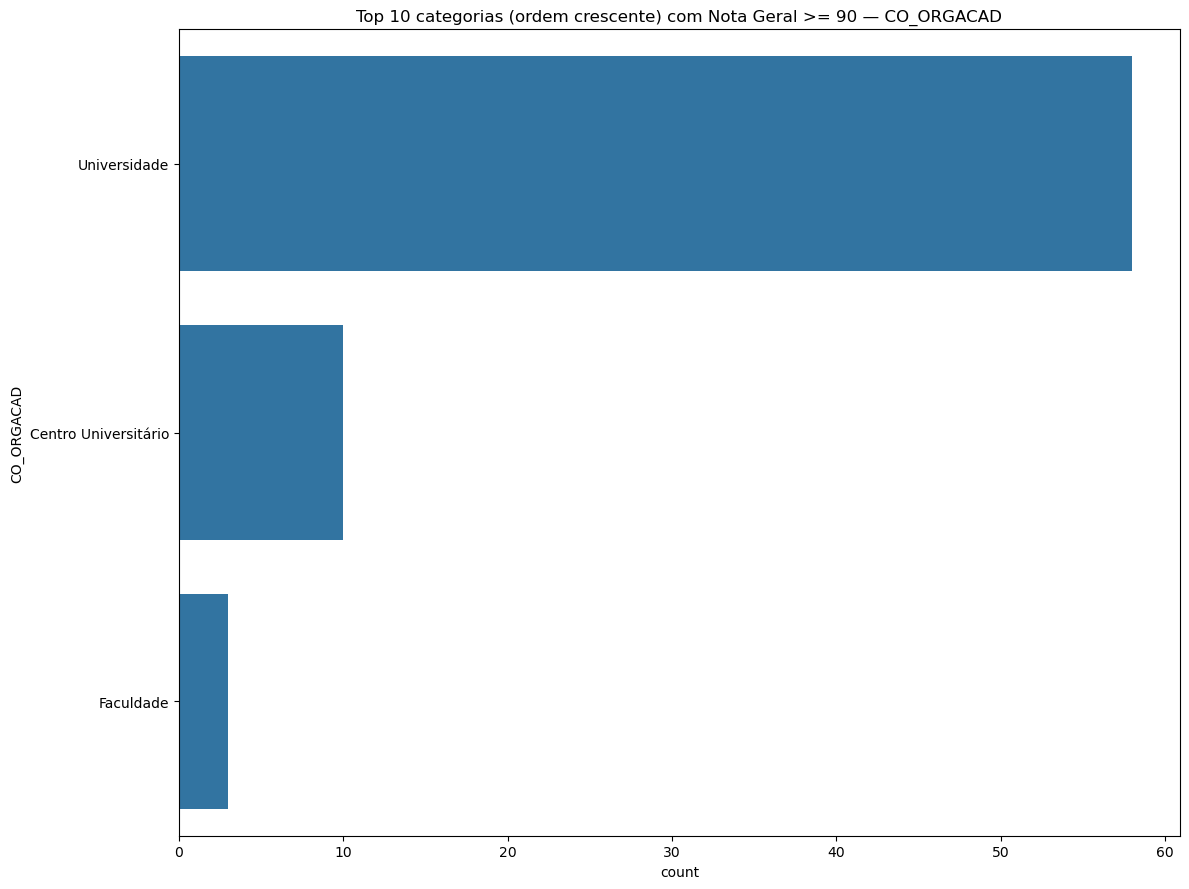

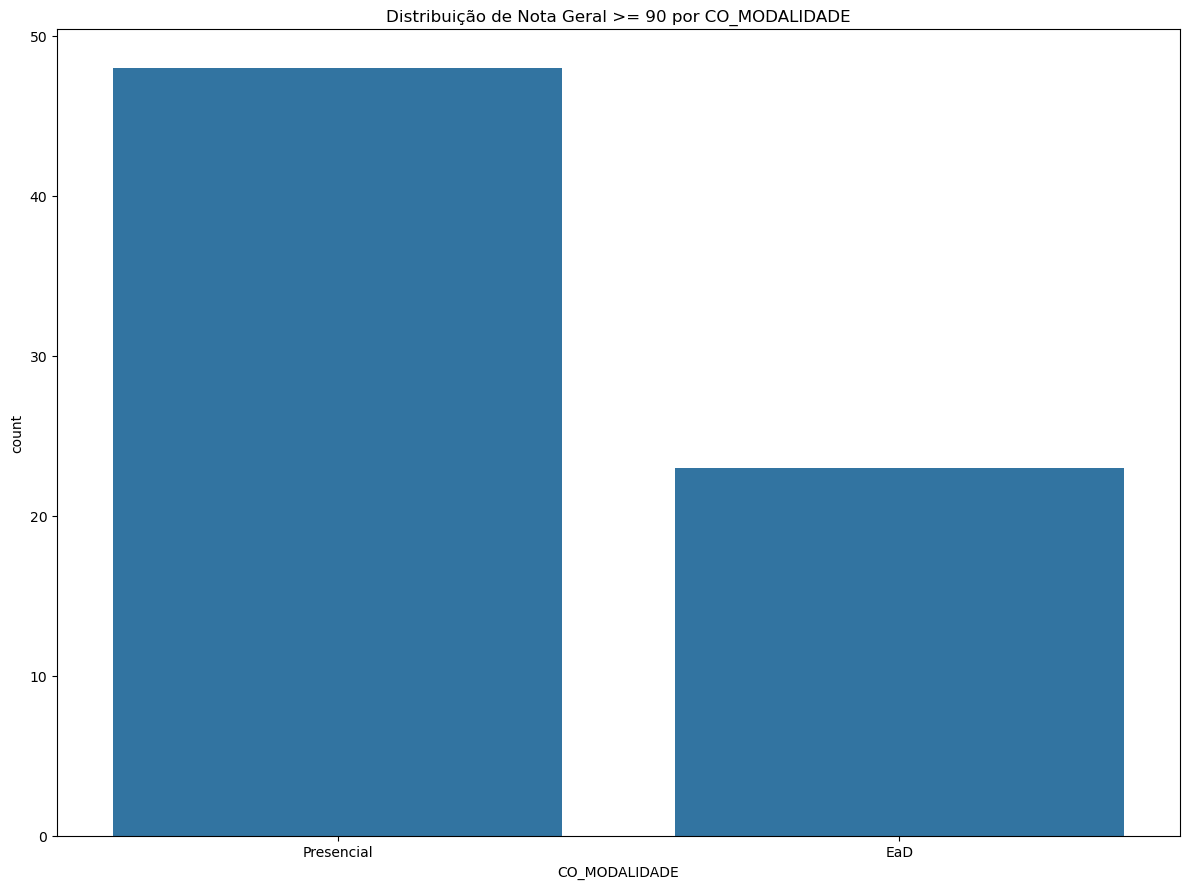

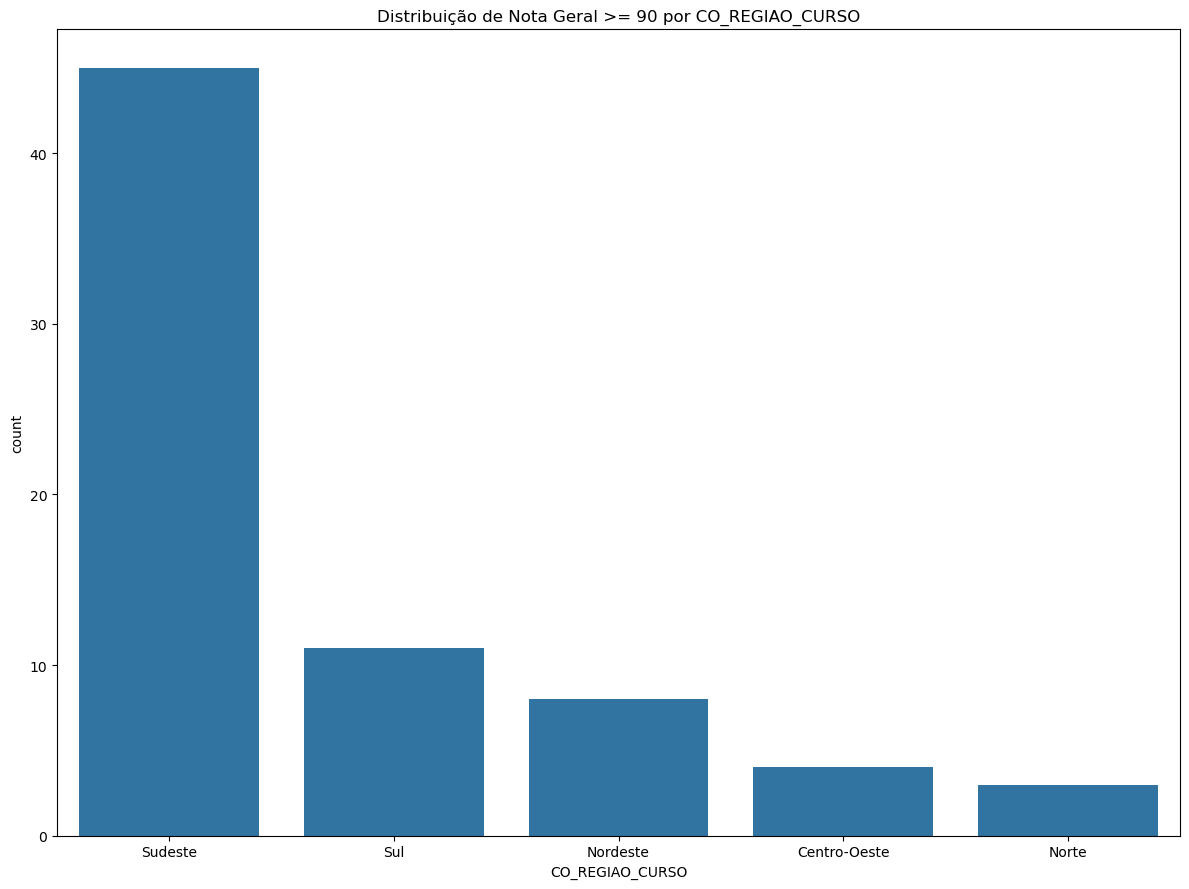

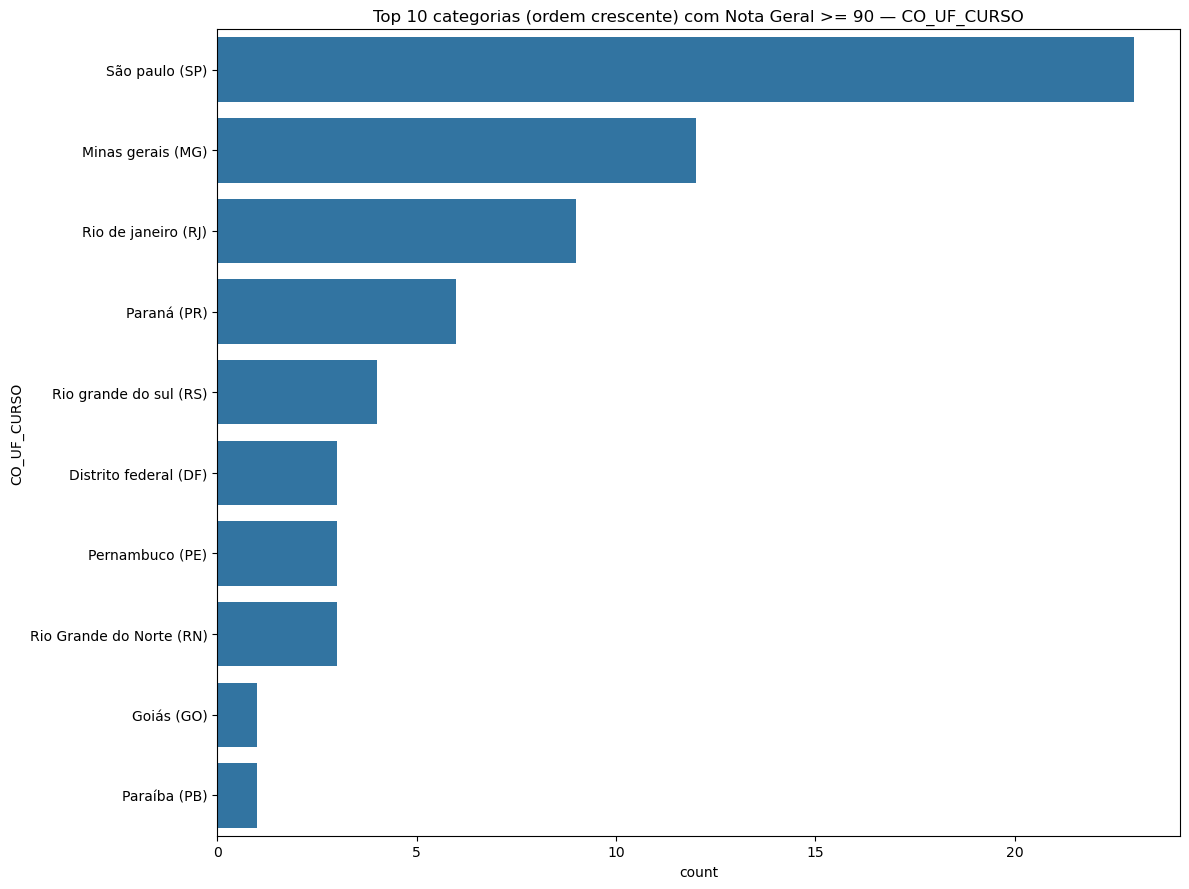

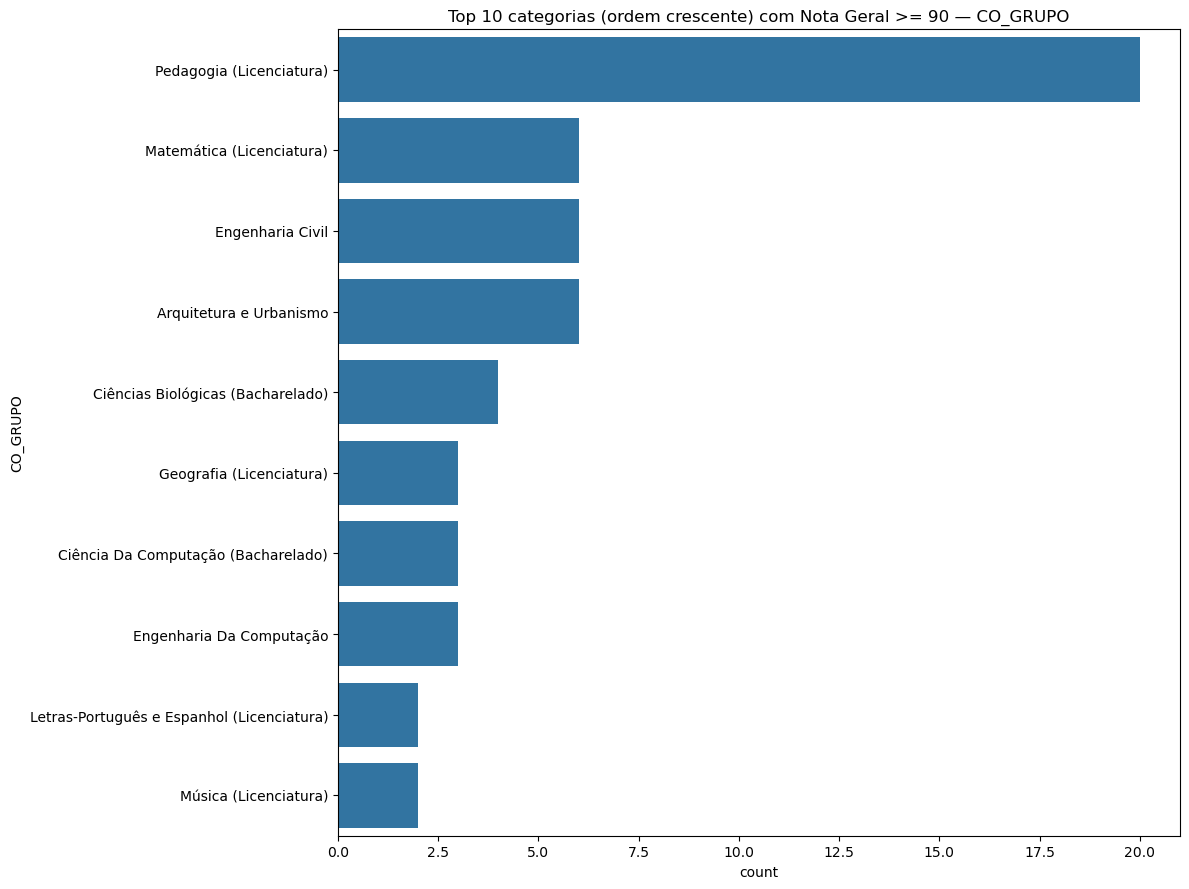

In [195]:
cols_analise = [
    "CO_CATEGAD",
    "CO_ORGACAD",
    "CO_MODALIDADE",
    "CO_REGIAO_CURSO",
    "CO_UF_CURSO",
    "CO_GRUPO",
]

high_cardinality = {"CO_UF_CURSO", "CO_GRUPO", "CO_ORGACAD"}

for col in cols_analise:
    is_high = col in high_cardinality

    plot_count_categorico(
        data=df_90,
        col=col,
        mapas=mapas,
        top_n=10 if is_high else None,
        horizontal=is_high,
        ascending=False,
        title=(
            f"Top 10 categorias (ordem crescente) com Nota Geral >= 90 — {col}"
            if is_high
            else f"Distribuição de Nota Geral >= 90 por {col}"
        )
    )


In [196]:
df_model = df_institucional.copy()
df_model["NT_GER_ZERO"] = (df_model["NT_GER"] == 0).astype(int)
df_model["NT_GER_ZERO"].value_counts(normalize=True)

NT_GER_ZERO
0    0.998466
1    0.001534
Name: proportion, dtype: float64

In [198]:
variaveis = [
    "CO_MODALIDADE",
    "CO_CATEGAD",
    "CO_REGIAO_CURSO",
    "CO_ORGACAD",
    "CO_GRUPO",
]

X = df_model[variaveis]
y = df_model["NT_GER_ZERO"]
X_dummies = pd.get_dummies(X, drop_first=True)


In [211]:
import statsmodels.api as sm

X_logit = sm.add_constant(X_dummies)

modelo_logit = sm.Logit(y, X_logit).fit()

modelo_logit.summary()


         Current function value: 0.023520
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            NT_GER_ZERO   No. Observations:               449932
Model:                          Logit   Df Residuals:                   449926
Method:                           MLE   Df Model:                            5
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                  -1.051
Time:                        20:50:44   Log-Likelihood:                -10582.
converged:                      False   LL-Null:                       -5160.8
Covariance Type:            nonrobust   LLR p-value:                     1.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.124e+04   3.34e+05     -0.183      0.855   -7.16e+05    5.94e+05
CO_MODALIDADE       0.2393      0.110      2.172      0.030       0.023       0.455
CO_CATEGAD         -0.1426      0.026     -5.566      0.000      -0.193      -0.092
CO_REGIAO_CURSO     0.0603      0.037      1.617      0.106      -0.013       0.133
CO_ORGACAD          6.1062     33.339      0.183      0.855     -59.237      71.449
CO_GRUPO           -0.0001   1.95e-05     -6.136      0.000      -0.000   -8.16e-05
===================================================================================

Possibly complete quasi-separation: A fraction 0.41 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [212]:
odds_ratios = pd.DataFrame({
    "Variavel": modelo_logit.params.index,
    "Coeficiente": modelo_logit.params.values,
    "Odds_Ratio": np.exp(modelo_logit.params.values)
}).sort_values("Odds_Ratio", ascending=False)

odds_ratios


,Variavel,Coeficiente,Odds_Ratio
4,CO_ORGACAD,6.106156,448.610970
1,CO_MODALIDADE,0.239285,1.270340
3,CO_REGIAO_CURSO,0.060318,1.062174
5,CO_GRUPO,-0.000120,0.999880
2,CO_CATEGAD,-0.142570,0.867127
0,const,-61238.118928,0.000000


In [213]:
from sklearn.metrics import roc_auc_score

prob = modelo_logit.predict(X_logit)

roc_auc_score(y, prob)


0.6701677702002258

In [214]:
variaveis = [
    "CO_MODALIDADE",
    "CO_REGIAO_CURSO",
    "CO_CATEGAD",
    "CO_ORGACAD",
    "CO_GRUPO",
]

X = pd.get_dummies(df_model[variaveis], drop_first=True)
X = sm.add_constant(X)

modelo_logit = sm.Logit(y, X).fit(method="lbfgs", maxiter=200)


In [215]:
modelo_logit.mle_retvals

{'fopt': np.float64(0.6931471805599455),
 'gopt': array([4.98466435e-01, 3.97471173e-01, 1.52291680e+00, 1.67223603e+00,
        4.99723887e+03, 1.61504410e+03]),
 'fcalls': 3,
 'warnflag': 0,
 'converged': True,
 'iterations': 1}

In [216]:
or_final = pd.DataFrame({
    "Variavel": modelo_logit.params.index,
    "Coeficiente": modelo_logit.params.values,
    "Odds_Ratio": np.exp(modelo_logit.params.values),
    "IC_2.5%": np.exp(modelo_logit.conf_int()[0]),
    "IC_97.5%": np.exp(modelo_logit.conf_int()[1]),
    "p_value": modelo_logit.pvalues
}).sort_values("Odds_Ratio", ascending=False)

or_final


,Variavel,Coeficiente,Odds_Ratio,IC_2.5%,IC_97.5%,p_value
const,const,0.0,1.0,6.576055e-09,1.520668e+08,1.0
CO_MODALIDADE,CO_MODALIDADE,0.0,1.0,9.845391e-01,1.015704e+00,1.0
CO_REGIAO_CURSO,CO_REGIAO_CURSO,0.0,1.0,9.938322e-01,1.006206e+00,1.0
CO_CATEGAD,CO_CATEGAD,0.0,1.0,9.957347e-01,1.004284e+00,1.0
CO_ORGACAD,CO_ORGACAD,0.0,1.0,9.981231e-01,1.001880e+00,1.0
CO_GRUPO,CO_GRUPO,0.0,1.0,9.999971e-01,1.000003e+00,1.0


In [217]:
X = pd.get_dummies(
    df_model[
        ["CO_MODALIDADE", "CO_CATEGAD", "CO_REGIAO_CURSO"]
    ],
    drop_first=True
)

X = sm.add_constant(X)
modelo_logit = sm.Logit(y, X).fit(method="lbfgs", maxiter=200)

In [218]:
modelo_logit.mle_retvals

{'fopt': np.float64(0.011232238893069287),
 'gopt': array([ 1.02191350e-06, -5.88267282e-07,  5.98373152e-06,  2.90979071e-06]),
 'fcalls': 24,
 'warnflag': 0,
 'converged': True,
 'iterations': 21}

In [221]:
mapas['CO_CATEGAD']

{'1': 'Pública Federal',
 '2': 'Pública Estadual',
 '3': 'Pública Municipal',
 '4': 'Privada com fins lucrativos',
 '5': 'Privada sem fins lucrativos',
 '7': 'Especial'}

In [219]:
or_final = pd.DataFrame({
    "Variavel": modelo_logit.params.index,
    "Coeficiente": modelo_logit.params.values,
    "Odds_Ratio": np.exp(modelo_logit.params.values),
    "IC_2.5%": np.exp(modelo_logit.conf_int()[0]),
    "IC_97.5%": np.exp(modelo_logit.conf_int()[1]),
    "p_value": modelo_logit.pvalues
}).sort_values("Odds_Ratio", ascending=False)

or_final


,Variavel,Coeficiente,Odds_Ratio,IC_2.5%,IC_97.5%,p_value
CO_REGIAO_CURSO,CO_REGIAO_CURSO,0.068202,1.070581,0.995268,1.151594,6.687364e-02
CO_MODALIDADE,CO_MODALIDADE,0.002773,1.002777,0.811158,1.239662,9.795520e-01
CO_CATEGAD,CO_CATEGAD,-0.351646,0.703529,0.669545,0.739238,4.751117e-44
const,const,-5.663404,0.003471,0.002478,0.004861,3.667736e-238


##### Socioeconômico

##### Engajamento